# 🔍 Data Preprocessing Strategy: From Initial Cleaning to Balanced Dataset for Model Training

---

## ✅ Step 1 – Initial Metadata Inspection and Age Analysis

We began by inspecting the `meta_train.csv` which contains the original image metadata, including `image_id`, `age`, and `variety`.  
We visualized the distribution of ages and identified strong age imbalance — most samples clustered around **65–70 days**, while fewer samples appeared near **45 or 80 days**.

> **Why we do this first:**  
> Early distribution insight helps guide whether rebalancing is needed.  
> For regression tasks, skewed distributions can bias the model toward common age ranges.

✅ **Age binning** (e.g., rounding to nearest 10) allowed us to stratify based on age class for later use.

---

## ✅ Step 2 – Correlation Check Between Metadata Features

We computed a correlation heatmap between encoded variety, label, and age to understand feature relationships:

- 📉 Very weak correlation between variety and age (near zero)
- 📊 No concerning collinearity found

> **Why this is useful:**  
> Confirms that variety can be used as an auxiliary feature (e.g., for SMOTE stratification) without introducing label leakage into age prediction.

---

## ✅ Step 3 – Data Cleaning + SMOTE Resampling

We loaded the original dataset, verified all image files existed, and filtered out:

- ❌ Corrupted files  
- ❌ Duplicates (by hash)  
- ❌ Missing files (from metadata but not in filesystem)

➡️ This left us with **10,333 unique valid samples**.

Then, we used **SMOTE (Synthetic Minority Oversampling Technique)** to synthetically rebalance rare age ranges:

- Stratified over `age_bin` and `variety_encoded`
- Resampled to get a **balanced distribution across all age groups**

> **Why not just augment directly?**  
> Without SMOTE, augmentation would oversample common ages again, reinforcing the bias.

---

## ✅ Step 4 – Assigning Resampled Ages to Real Images

SMOTE returns **synthetic points in feature space** (not image-level data).  
We matched resampled ages back to actual images by:

- Sampling randomly from existing images in each `age_bin`
- Assigning the synthetic ages to those images

> **Why we do this:**  
> Makes it possible to generate image augmentations that reflect underrepresented ages, helping the model learn rare age patterns.

---

## ✅ Step 5 – Apply Augmentation and Save Metadata

Using **Albumentations**, we:

- Applied random transforms (flip, rotate, zoom, etc.)
- Saved the augmented images to a flat folder: `~/Desktop/augmented_images`
- Saved metadata to `meta_aug_train.csv` to match filenames with synthetic age and variety

📈 We now had **19,600 total records** (original + augmented) with improved class balance.

---

## ✅ Step 6 – Final Merge, Path Assignment & Filtering

In the final prep script, we:

1. Merged `meta_train.csv` and `meta_aug_train.csv`
2. Built `full_path` for each image:
   - Originals: `full_dataset/train/<label>/<image_id>`
   - Augmented: `augmented_images/<filename>`
3. Filtered again to remove missing files (due to move/deletion)
4. Performed train/val split (80/20) on the full combined dataset

> **Why split after filtering?**  
> To avoid broken validation sets.  

> **Why use both original and augmented data?**  
> To ensure the model sees both natural and synthetically rebalanced distributions.

---

## ✅ Key Benefits of This Design

- 🎯 **Data-driven balancing**: SMOTE ensures all age classes are represented more equally.
- 🧠 **Preserves semantic structure**: We don’t fabricate images from noise — only augment real ones and map SMOTE ages to them.
- 🛠️ **Modular & traceable**: Separate CSVs and folders for original vs. augmented data help with debugging and reproducibility.

---

## 🆚 Why Script 2 (Final Version) Is Better Than Script 1

| Feature                     | Script 1                  | Script 2 (Improved)                         |
|-----------------------------|----------------------------|----------------------------------------------|
| Uses raw age distribution   | ✅ Yes                     | ✅ Yes                                       |
| Fixes missing label paths   | ❌ No                      | ✅ Yes (label folder included)              |
| Checks for missing files    | ❌ Only after split        | ✅ Before and after split                   |
| SMOTE age balancing         | ❌ No                      | ✅ Yes (on variety + age bin)               |
| Augmentation strategy       | ❌ Rescale only            | ✅ Albumentations + metadata tracking       |
| Final val set integrity     | ❌ Might be empty          | ✅ Retry logic to ensure non-empty val set  |

---

✅ You can now safely train on this dataset using consistent `df_train` and `df_val`,  
knowing the age distribution is more even and validated images are intact.


Loaded meta_train.csv. Shape: (10407, 4)


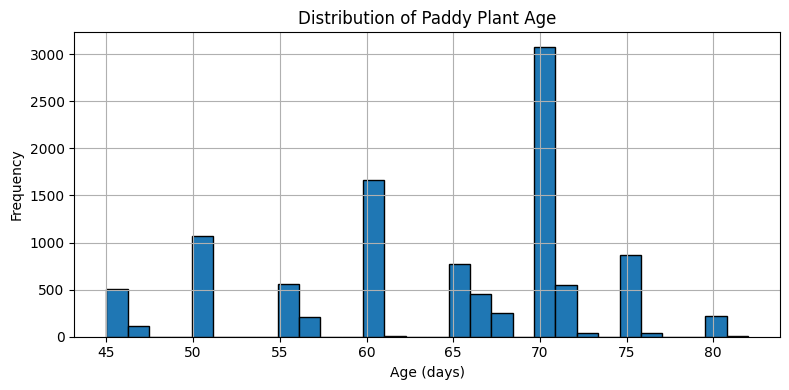

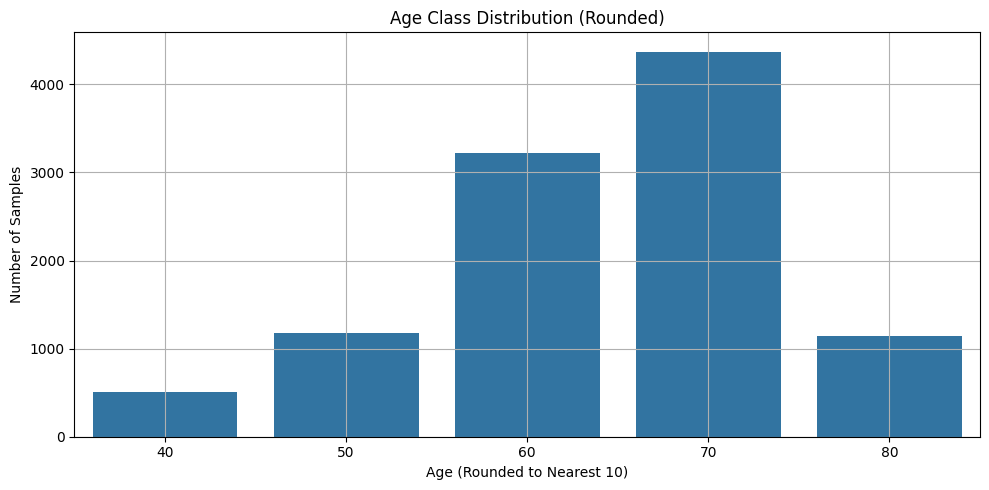

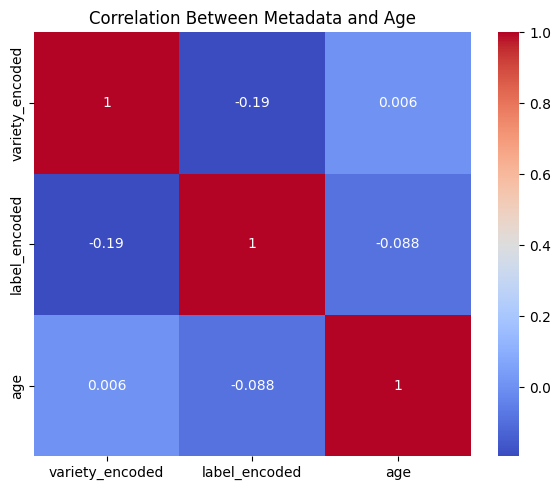

Found image: 100330.jpg
Original size: (480, 640)


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# === Future-Proof Path Setup === #
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))

PATHS = {
    "csv": os.path.join(BASE_PATH, "meta_train.csv"),
    "train_images": os.path.join(BASE_PATH, "dataset", "train"),
    "val_images": os.path.join(BASE_PATH, "dataset", "val"),  # Optional for later use
    "test_images": os.path.join(BASE_PATH, "test_images"),
}


# === Load Data === #
df = pd.read_csv(PATHS["csv"])
print("Loaded meta_train.csv. Shape:", df.shape)

# === Plot Age Distribution === #
plt.figure(figsize=(8, 4))
plt.hist(df['age'], bins=30, edgecolor='black')
plt.title('Distribution of Paddy Plant Age')
plt.xlabel('Age (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot Age Distribution Cleanly === #
df['age_class'] = df['age'].round(-1).astype(int)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='age_class', order=sorted(df['age_class'].unique()))
plt.title("Age Class Distribution (Rounded)")
plt.xlabel("Age (Rounded to Nearest 10)")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()


# === Correlation Heatmap === #
df['variety_encoded'] = df['variety'].astype('category').cat.codes
df['label_encoded'] = df['label'].astype('category').cat.codes

plt.figure(figsize=(6, 5))
sns.heatmap(df[['variety_encoded', 'label_encoded', 'age']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Metadata and Age')
plt.tight_layout()
plt.show()

from pathlib import Path
from PIL import Image

sample_image_id = df['image_id'].iloc[0]  # e.g., '100330.jpg'
found_path = None

# Recursively search for the image in all subfolders of train_images/
for root, dirs, files in os.walk(PATHS["train_images"]):
    if sample_image_id in files:
        found_path = os.path.join(root, sample_image_id)
        break

if found_path:
    img = Image.open(found_path)
    print(f"Found image: {sample_image_id}")
    print(f"Original size: {img.size}")
    img.show()
else:
    print(f"Image {sample_image_id} not found in any subfolder of train_images/")


In [41]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
import albumentations as A
import random

# === CONFIG ===
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))

PATHS = {
    "train_images": os.path.join(BASE_PATH, "dataset", "train"),
    "augmented_images": os.path.expanduser("~/Desktop/augmented_images"),
    "augmented_csv": os.path.expanduser("~/Desktop/meta_aug_train.csv"),
    "meta_csv": os.path.join(BASE_PATH, "meta_train.csv")
}


os.makedirs(PATHS["augmented_images"], exist_ok=True)

# === Load Original CSV ===
df = pd.read_csv(PATHS["meta_csv"])
df['variety_encoded'] = df['variety'].astype('category').cat.codes

# === Step 1: Bin age
df['age_bin'] = pd.cut(df['age'], bins=5, labels=False)

# === Step 2: Apply SMOTE on (age, variety), stratified by age_bin
X = df[['age', 'variety_encoded']].values
y = df['age_bin'].values
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# === Step 3: Build resampled DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=['age', 'variety_encoded'])
df_resampled['age_bin'] = y_resampled

# === Step 4: Decode variety
variety_map = dict(enumerate(df['variety'].astype('category').cat.categories))
df_resampled['variety'] = df_resampled['variety_encoded'].map(variety_map)

# === Step 5: Map age_bin to image_ids
df_original = df[['image_id', 'age_bin']]  # only needed columns
bin_to_images = df_original.groupby("age_bin")['image_id'].apply(list).to_dict()

assigned_ids = []
for _, row in df_resampled.iterrows():
    bin_id = row['age_bin']
    candidates = bin_to_images.get(bin_id, [])
    assigned_ids.append(random.choice(candidates) if candidates else None)

df_resampled['image_id'] = assigned_ids

# === Step 6: Define Augmentation Pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomCrop(width=224, height=224),
    A.Resize(256, 256)
])

# === Step 7: Generate Augmented Images
augmented_records = []

for i, row in tqdm(df_resampled.iterrows(), total=len(df_resampled)):
    image_filename = row.get('image_id')
    if image_filename is None:
        continue

    # Find image path
    image_path = None
    for root, dirs, files in os.walk(PATHS["train_images"]):
        if image_filename in files:
            image_path = os.path.join(root, image_filename)
            break
    if image_path is None:
        continue

    try:
        image = np.array(Image.open(image_path).convert("RGB"))
    except Exception as e:
        print(f"❌ Failed to load {image_path}: {e}")
        continue

    transformed = transform(image=image)['image']
    new_filename = f"aug_{i}_{image_filename}"
    save_path = os.path.join(PATHS["augmented_images"], new_filename)
    Image.fromarray(transformed).save(save_path)

    augmented_records.append({
        'image_id': new_filename,
        'variety': row['variety'],
        'age': row['age']
    })

# === Step 8: Save Metadata CSV
df_augmented = pd.DataFrame(augmented_records)
df_augmented.to_csv(PATHS["augmented_csv"], index=False)
print(f"✅ Augmented {len(df_augmented)} images saved to: {PATHS['augmented_images']}")
print(f"✅ Metadata saved to: {PATHS['augmented_csv']}")


/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
100%|████████████████████████████████████| 19600/19600 [01:44<00:00, 188.43it/s]

✅ Augmented 15617 images saved to: /Users/anluu/Desktop/augmented_images
✅ Metadata saved to: /Users/anluu/Desktop/meta_aug_train.csv


/var/folders/l_/2tbf5tf961vg06w5znf_dhnr0000gn/T/ipykernel_8394/820795088.py:11: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


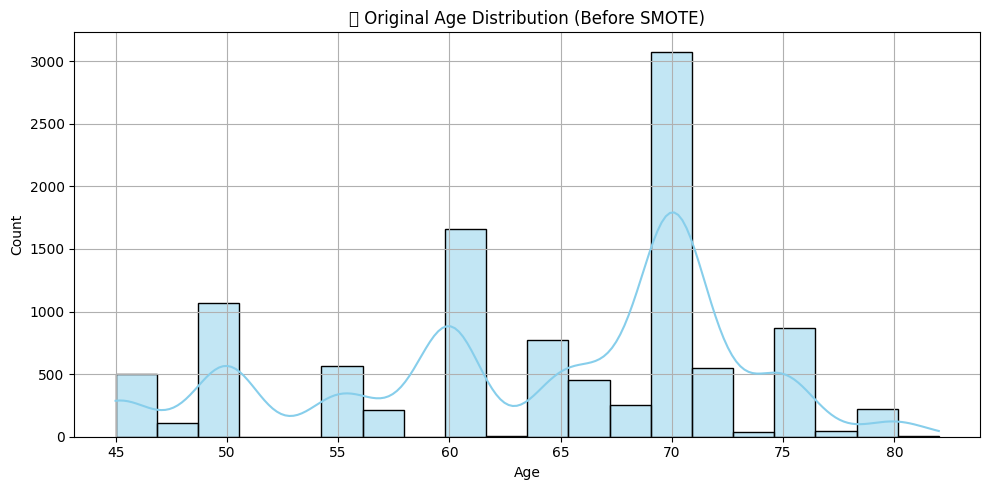

/var/folders/l_/2tbf5tf961vg06w5znf_dhnr0000gn/T/ipykernel_8394/820795088.py:21: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


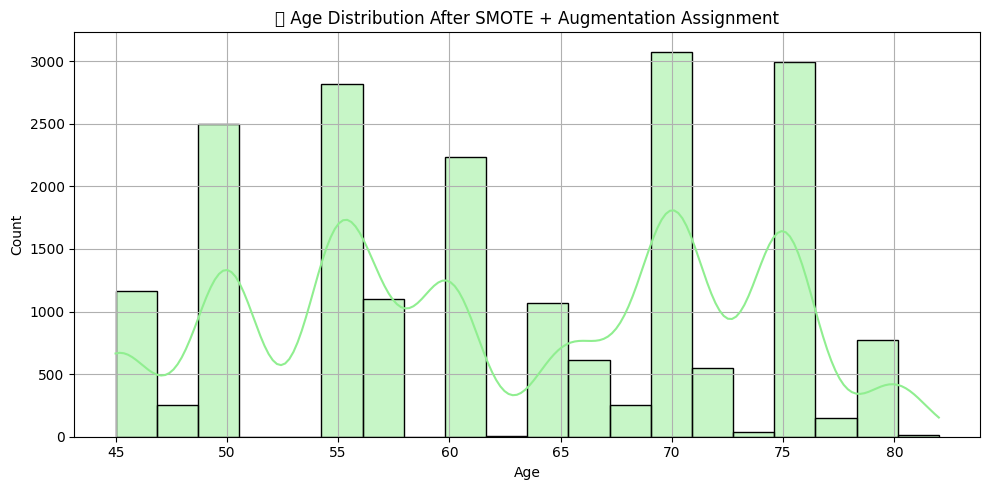

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Before: Original Age Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['age'], bins=20, kde=True, color="skyblue")
plt.title("📉 Original Age Distribution (Before SMOTE)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# === After: Resampled Age Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_resampled['age'], bins=20, kde=True, color="lightgreen")
plt.title("📈 Age Distribution After SMOTE + Augmentation Assignment")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# === CONFIG: adjust paths ===
IMG_DIR_ORIG = os.path.expanduser("~/Desktop/full_dataset/train")
IMG_DIR_AUG = os.path.expanduser("~/Desktop/augmented_images")           
META_TRAIN_CSV = os.path.expanduser("~/Desktop/meta_train.csv")
META_AUG_CSV = os.path.expanduser("~/Desktop/meta_aug_train.csv")

# === Step 1: Load CSVs
df_orig = pd.read_csv(META_TRAIN_CSV)
df_aug = pd.read_csv(META_AUG_CSV)

df_orig['filename'] = df_orig['image_id']
df_aug['filename'] = df_aug['image_id']

df_aug['label'] = df_aug['variety']  # ✅ Add this line

# === Step 2: Add full path
def get_path(row):
    if row['filename'].startswith('aug_'):
        # Augmented images are saved in a flat folder
        return os.path.join(IMG_DIR_AUG, row['filename'])
    else:
        # Original images are inside train/<label>/<filename>
        return os.path.join(IMG_DIR_ORIG, row['label'], row['filename'])


df_orig['full_path'] = df_orig.apply(get_path, axis=1)
df_aug['full_path'] = df_aug.apply(get_path, axis=1)


df_orig['full_path'] = df_orig.apply(get_path, axis=1)
df_aug['full_path'] = df_aug.apply(get_path, axis=1)

# === Step 3: Combine for training
df_combined = pd.concat([df_orig, df_aug], ignore_index=True)

# === Step 4: Train/Val split
df_train, df_val = train_test_split(df_combined, test_size=0.2, random_state=42)

# === Step 5: Check for missing files
missing_train = df_train[~df_train['full_path'].apply(os.path.exists)]
missing_val = df_val[~df_val['full_path'].apply(os.path.exists)]

print(f"❌ Missing training files: {missing_train.shape[0]}")
print(f"❌ Missing validation files: {missing_val.shape[0]}")
print("🔍 Example missing val paths:")
print(missing_val[['filename', 'full_path']].head())

# === Step 6: Remove missing
df_train = df_train[df_train['full_path'].apply(os.path.exists)].copy()
df_val = df_val[df_val['full_path'].apply(os.path.exists)].copy()

# === Step 7: Fallback if val is empty
if df_val.empty:
    print("⚠️ WARNING: df_val is empty after filtering! Retrying split...")
    df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
    df_train['full_path'] = df_train.apply(get_path, axis=1)
    df_val['full_path'] = df_val.apply(get_path, axis=1)
    df_train = df_train[df_train['full_path'].apply(os.path.exists)].copy()
    df_val = df_val[df_val['full_path'].apply(os.path.exists)].copy()

print("✅ Final Train shape:", df_train.shape)
print("✅ Final Val shape:", df_val.shape)


❌ Missing training files: 1649
❌ Missing validation files: 433
🔍 Example missing val paths:
        filename                                          full_path
2583  108538.jpg  /Users/anluu/Desktop/full_dataset/train/blast/...
7639  105055.jpg  /Users/anluu/Desktop/full_dataset/train/normal...
7428  106229.jpg  /Users/anluu/Desktop/full_dataset/train/hispa/...
8880  108652.jpg  /Users/anluu/Desktop/full_dataset/train/normal...
1227  105360.jpg  /Users/anluu/Desktop/full_dataset/train/blast/...
✅ Final Train shape: (19170, 6)
✅ Final Val shape: (4772, 6)


✅ Final Train shape: (12493, 6)
✅ Final Val shape: (3124, 6)
Found 12493 validated image filenames.
Found 3124 validated image filenames.
Epoch 1/50


2025-06-05 10:21:28.134946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - ETA: 0s - loss: 0.1963 - mae: 0.5060 - rmse: 0.6370 - r_squared: -4.9029

2025-06-05 10:22:41.550980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - 85s 192ms/step - loss: 0.1963 - mae: 0.5060 - rmse: 0.6370 - r_squared: -4.9029 - val_loss: 0.1010 - val_mae: 0.3718 - val_rmse: 0.4469 - val_r_squared: -1.8480
Epoch 2/50
391/391 [==============================] - 74s 188ms/step - loss: 0.1657 - mae: 0.4631 - rmse: 0.5795 - r_squared: -3.8366 - val_loss: 0.0982 - val_mae: 0.3651 - val_rmse: 0.4407 - val_r_squared: -1.7694
Epoch 3/50
391/391 [==============================] - 73s 186ms/step - loss: 0.1619 - mae: 0.4571 - rmse: 0.5731 - r_squared: -3.7413 - val_loss: 0.0849 - val_mae: 0.3362 - val_rmse: 0.4096 - val_r_squared: -1.3911
Epoch 4/50
391/391 [==============================] - 73s 186ms/step - loss: 0.1622 - mae: 0.4576 - rmse: 0.5726 - r_squared: -3.7638 - val_loss: 0.0757 - val_mae: 0.3175 - val_rmse: 0.3866 - val_r_squared: -1.1298
Epoch 5/50
391/391 [==============================] - 73s 187ms/step - loss: 0.1625 - mae: 0.4584 - rmse: 0.5745 - r_squared: -3.7680 - val_loss: 0.068

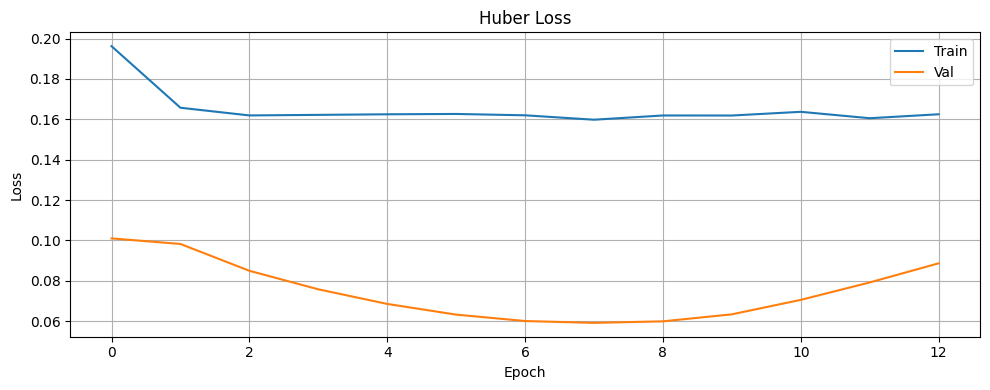

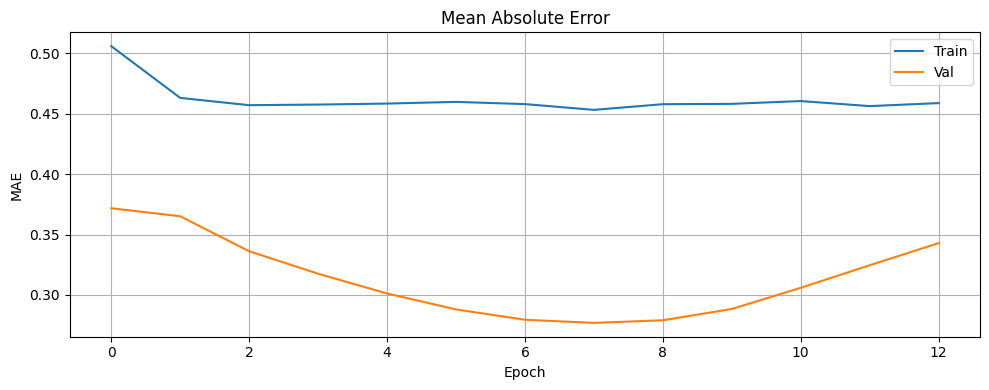

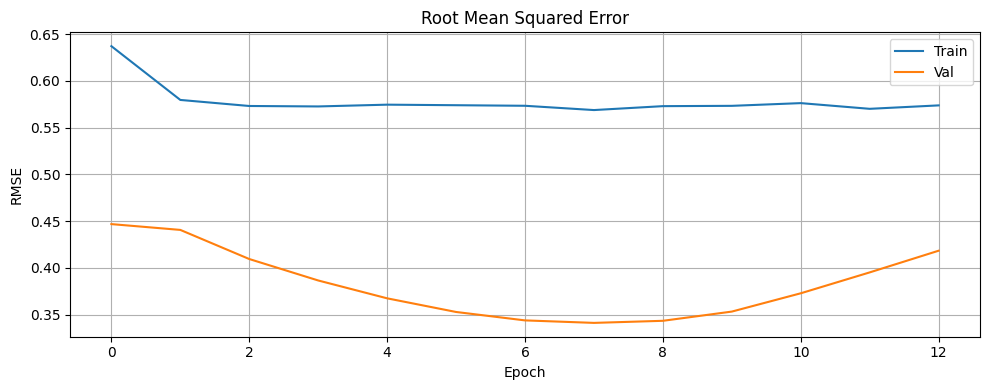

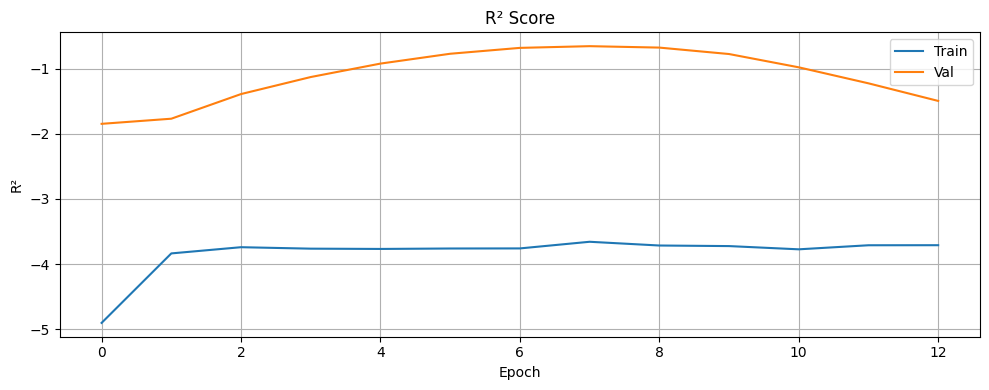


🔎 Sample denormalized age values (first 10 from validation set):
True ages: [55. 50. 45. 70. 55. 60. 70. 55. 70. 75.]


In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.losses import Huber
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

# === CONFIG ===
IMG_DIR_ORIG = os.path.expanduser("~/Desktop/full_dataset/train")
IMG_DIR_AUG = os.path.expanduser("~/Desktop/augmented_images")
ORIG_CSV = os.path.expanduser("~/Desktop/meta_train.csv")
AUG_CSV = os.path.expanduser("~/Desktop/meta_aug_train.csv")
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 50


# === Load Data ===
df_orig = pd.read_csv(ORIG_CSV)
df_aug = pd.read_csv(AUG_CSV)

df_orig["filename"] = df_orig["image_id"]
df_aug["filename"] = df_aug["image_id"]
df_orig["age"] = df_orig["age"].astype(float)
df_aug["age"] = df_aug["age"].astype(float)

# === Normalize Age ===
scaler = MinMaxScaler()
df_orig["age"] = scaler.fit_transform(df_orig[["age"]])
df_aug["age"] = scaler.transform(df_aug[["age"]])

# === Combine and Split ===
df_combined = pd.concat([df_orig, df_aug], ignore_index=True)
df_combined["full_path"] = df_combined.apply(
    lambda row: os.path.join(IMG_DIR_AUG if row["filename"].startswith("aug_") else IMG_DIR_ORIG, row["filename"]),
    axis=1,
)

# Remove missing
df_combined = df_combined[df_combined["full_path"].apply(os.path.exists)].copy()
df_train, df_val = train_test_split(df_combined, test_size=0.2, random_state=42)

print("✅ Final Train shape:", df_train.shape)
print("✅ Final Val shape:", df_val.shape)

# === Data Generators (no augmentation) ===
train_gen = ImageDataGenerator(rescale=1.0 / 255).flow_from_dataframe(
    dataframe=df_train,
    x_col="full_path",
    y_col="age",
    target_size=IMG_SIZE,
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_gen = ImageDataGenerator(rescale=1.0 / 255).flow_from_dataframe(
    dataframe=df_val,
    x_col="full_path",
    y_col="age",
    target_size=IMG_SIZE,
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# === Custom Metrics ===
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# === Build Model ===
base = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))
base.trainable = True

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.5)(x)
out = Dense(1, kernel_regularizer=l2(1e-4))(x)

lr_schedule = CosineDecay(initial_learning_rate=1e-4, decay_steps=1000, alpha=1e-6)

model = Model(inputs=base.input, outputs=out)
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=Huber(),
    metrics=["mae", rmse, r_squared],
)

# === Train Model ===
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=[early_stop])

# === Plotting Function ===
def plot_metric(metric_name, title, ylabel):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history[metric_name], label="Train")
    plt.plot(history.history[f"val_{metric_name}"], label="Val")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metric("loss", "Huber Loss", "Loss")
plot_metric("mae", "Mean Absolute Error", "MAE")
plot_metric("rmse", "Root Mean Squared Error", "RMSE")
plot_metric("r_squared", "R² Score", "R²")

# === Denormalize Example (optional)
print("\n🔎 Sample denormalized age values (first 10 from validation set):")
ages_val_true = scaler.inverse_transform(df_val[["age"]].values)
print("True ages:", ages_val_true[:10].reshape(-1))


🧠 Why We Changed the Data Splitting Strategy (Script 1 → Script 2)
In our earlier experiments, we used a simple random split of the dataset:

python
df_combined = pd.concat([df_orig, df_aug], ignore_index=True)
df_combined = df_combined[df_combined["full_path"].apply(os.path.exists)]
df_train, df_val = train_test_split(df_combined, test_size=0.2, random_state=42)

This approach was quick and easy, but it had a few hidden issues:

⚠️ Data leakage risk: Augmented images (e.g., flipped or rotated versions) could end up in the validation set, making the model appear better than it really is.

⚠️ Unbalanced validation: Since the split is random, the age distribution in df_val could be skewed, especially for underrepresented age groups.

✅ Advantage: It uses the full set of augmented images, giving us more data overall during training.

✅ Improved Strategy (Script 2)
In the updated script, we changed the pipeline to improve generalization and evaluation reliability:

python
# Step 1: Split original data only (no augmentation)
df_orig['age_bin'] = pd.cut(df_orig['age'], bins=5, labels=False)
df_train_base, df_val = train_test_split(df_orig, test_size=0.2, stratify=df_orig['age_bin'], random_state=42)

# Step 2: Add sampled augmented data to training only
df_aug_sampled = df_aug.sample(frac=0.5, random_state=42)
df_train = pd.concat([df_train_base, df_aug_sampled], ignore_index=True)

This improves our workflow in several ways:

✅ No augmented images in validation set: Ensures fair, realistic model evaluation.

✅ Stratified splitting by age: Maintains similar age distributions in both training and validation sets, which is important for regression tasks.

✅ Reduced risk of overfitting: Model doesn't get credit for seeing artificially enhanced data in validation.

✅ Clean separation of original vs. augmented data.

📌 Summary
Aspect	Script 1	Script 2
Split Method	Random on full data	Stratified on original data
Augmented Data in Val?	❌ Possibly	✅ Never
Stratified by Age?	❌ No	✅ Yes (via age bins)
Evaluation Reliability	⚠️ Lower	✅ Higher
Usage	Quick prototyping	Final model training/evaluation

We use Script 1 for quick testing, but Script 2 is preferred for final model runs and fair evaluation.

✅ Final Train shape: (9769, 7)
✅ Final Val shape: (1679, 7)
Found 9769 validated image filenames.
Found 1679 validated image filenames.
Epoch 1/50


2025-06-05 16:13:04.031755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - ETA: 0s - loss: 62.8377 - mae: 63.3377 - rmse: 64.0109 - r_squared: -49.1046

2025-06-05 16:14:18.467833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - 81s 249ms/step - loss: 62.8377 - mae: 63.3377 - rmse: 64.0109 - r_squared: -49.1046 - val_loss: 62.9233 - val_mae: 63.4233 - val_rmse: 64.0299 - val_r_squared: -53.4355
Epoch 2/50
306/306 [==============================] - 72s 237ms/step - loss: 59.8980 - mae: 60.3980 - rmse: 61.2311 - r_squared: -44.9846 - val_loss: 58.4050 - val_mae: 58.9050 - val_rmse: 59.5575 - val_r_squared: -46.1050
Epoch 3/50
306/306 [==============================] - 72s 235ms/step - loss: 55.1472 - mae: 55.6472 - rmse: 56.6406 - r_squared: -38.3630 - val_loss: 57.2161 - val_mae: 57.7161 - val_rmse: 58.4971 - val_r_squared: -44.4202
Epoch 4/50
306/306 [==============================] - 73s 237ms/step - loss: 48.8305 - mae: 49.3305 - rmse: 50.3468 - r_squared: -30.1350 - val_loss: 50.4752 - val_mae: 50.9752 - val_rmse: 51.7344 - val_r_squared: -34.5577
Epoch 5/50
306/306 [==============================] - 73s 237ms/step - loss: 38.7183 - mae: 39.2183 - rmse: 40.5153 - r

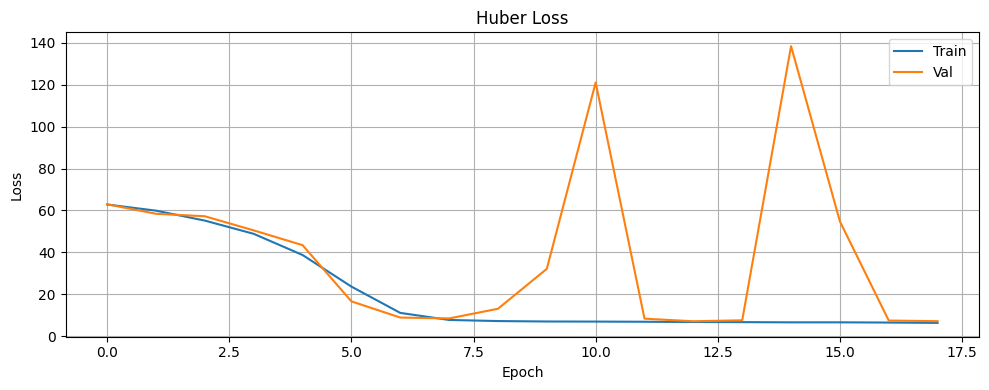

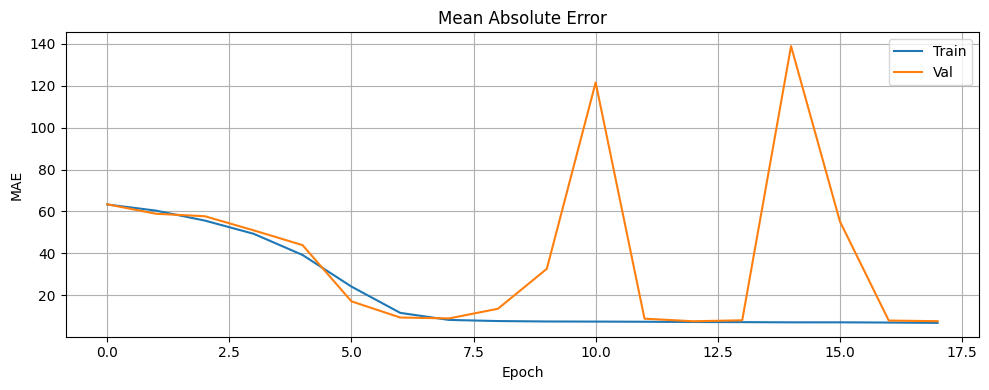

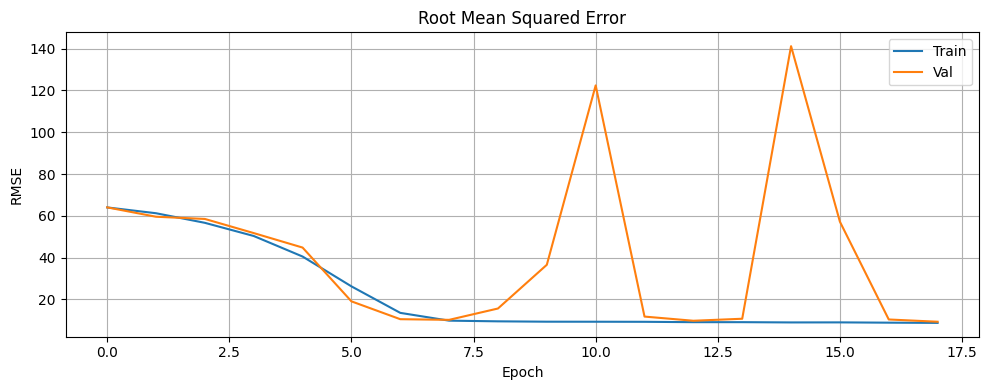

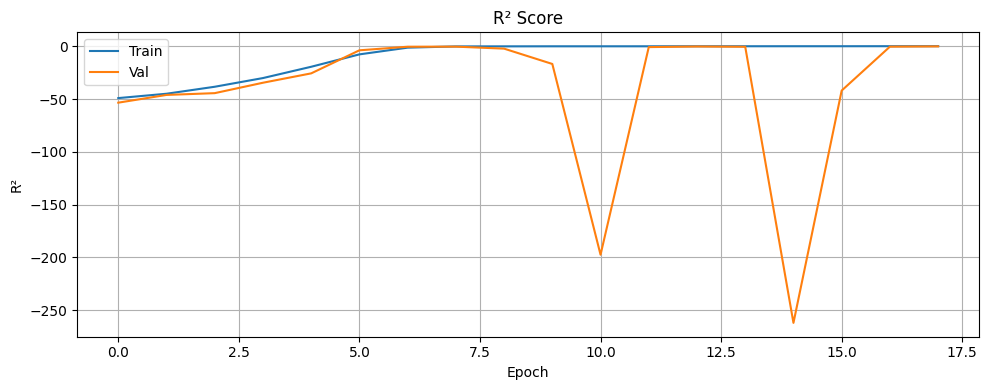

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.losses import Huber
import tensorflow.keras.backend as K

# === CONFIG ===
BASE_PATH = os.path.expanduser("~")
IMG_DIR_ORIG = os.path.join(BASE_PATH, "Desktop/full_dataset/train")
IMG_DIR_AUG = os.path.join(BASE_PATH, "Desktop/augmented_images")
ORIG_CSV = os.path.join(BASE_PATH, "Desktop/meta_train.csv")
AUG_CSV = os.path.join(BASE_PATH, "Desktop/meta_aug_train.csv")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

# === Load CSVs ===
df_orig = pd.read_csv(ORIG_CSV)
df_aug = pd.read_csv(AUG_CSV)
df_orig['filename'] = df_orig['image_id']
df_aug['filename'] = df_aug['image_id']
df_orig['age'] = df_orig['age'].astype(float)
df_aug['age'] = df_aug['age'].astype(float)

# Sample 20% of augmented images to prevent overfitting
df_aug_sampled = df_aug.sample(frac=0.2, random_state=42)

# Stratified split (by age bins)
df_orig['age_bin'] = pd.cut(df_orig['age'], bins=5, labels=False)
df_train_base, df_val = train_test_split(df_orig, test_size=0.2, stratify=df_orig['age_bin'], random_state=42)
df_train = pd.concat([df_train_base, df_aug_sampled], ignore_index=True)

# === Build file paths ===
def get_path(row):
    if str(row['filename']).startswith('aug_'):
        return os.path.join(IMG_DIR_AUG, row['filename'])
    else:
        label = row.get('label', '')
        return os.path.join(IMG_DIR_ORIG, label, row['filename']) if label else ''

df_train['full_path'] = df_train.apply(get_path, axis=1)
df_val['full_path'] = df_val.apply(get_path, axis=1)
df_train['full_path'] = df_train.apply(get_path, axis=1)
df_val['full_path'] = df_val.apply(get_path, axis=1)

# Check for missing
df_train = df_train[df_train['full_path'].apply(os.path.exists)].copy()
missing_val = df_val[~df_val['full_path'].apply(os.path.exists)].copy()
df_val = df_val[df_val['full_path'].apply(os.path.exists)].copy()

print("✅ Final Train shape:", df_train.shape)
print("✅ Final Val shape:", df_val.shape)

# Debug if val set is empty
if df_val.empty:
    print("⚠️ WARNING: df_val is empty after filtering! Retrying split...")
    df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

    if 'label' not in df_val.columns and 'variety' in df_val.columns:
        df_val['label'] = df_val['variety']
    if 'label' not in df_train.columns and 'variety' in df_train.columns:
        df_train['label'] = df_train['variety']

    df_train['full_path'] = df_train.apply(get_path, axis=1)
    df_val['full_path'] = df_val.apply(get_path, axis=1)
    df_train = df_train[df_train['full_path'].apply(os.path.exists)].copy()
    df_val = df_val[df_val['full_path'].apply(os.path.exists)].copy()



# === Data Generators (no augmentations needed) ===
train_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=df_train,
    x_col='full_path',
    y_col='age',
    target_size=IMG_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=df_val,
    x_col='full_path',
    y_col='age',
    target_size=IMG_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# === Custom Metrics ===
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

# === Learning Rate Warm-up + Cosine Decay ===
steps_per_epoch = len(train_gen)
total_steps = EPOCHS * steps_per_epoch
warmup_steps = int(0.1 * total_steps)

class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, warmup_steps, total_steps):
        super().__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.cosine = CosineDecay(initial_learning_rate=initial_lr, decay_steps=total_steps - warmup_steps)

    def __call__(self, step):
        return tf.cond(
            step < self.warmup_steps,
            lambda: self.initial_lr * tf.cast(step, tf.float32) / tf.cast(self.warmup_steps, tf.float32),
            lambda: self.cosine(step - self.warmup_steps)
        )

lr_schedule = WarmUpCosine(initial_lr=1e-4, warmup_steps=warmup_steps, total_steps=total_steps)

# === Build and compile model ===
base_model = EfficientNetV2B0(weights=None, include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
out = Dense(1)(x)

model = Model(inputs=base_model.input, outputs=out)
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=Huber(),
    metrics=['mae', rmse, r_squared]
)

# === Train ===
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=[early_stop])

# === Plot Metrics ===
def plot_metric(metric_name, title, ylabel):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history[metric_name], label="Train")
    plt.plot(history.history[f"val_{metric_name}"], label="Val")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric("loss", "Huber Loss", "Loss")
plot_metric("mae", "Mean Absolute Error", "MAE")
plot_metric("rmse", "Root Mean Squared Error", "RMSE")
plot_metric("r_squared", "R² Score", "R²")


# Debug for Worst Predictions by Absolute Error & KNN-Based Similarity Gap Detection

2025-06-05 12:09:07.877229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 5s 69ms/step

📷 File: 101050.jpg
🧷 True Age: 45.00 | 🔮 Predicted: 68.59 | ❌ Abs Error: 23.59


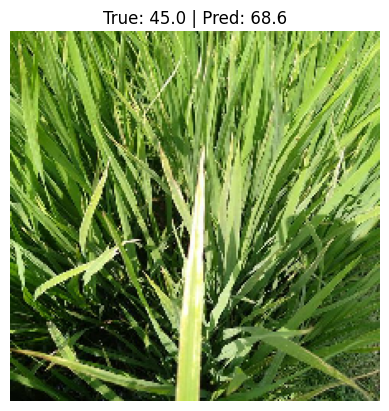


📷 File: 100813.jpg
🧷 True Age: 45.00 | 🔮 Predicted: 66.83 | ❌ Abs Error: 21.83


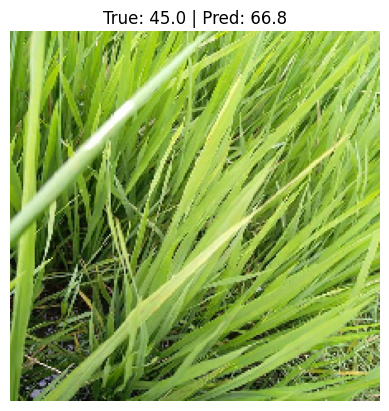


📷 File: 103163.jpg
🧷 True Age: 45.00 | 🔮 Predicted: 66.83 | ❌ Abs Error: 21.83


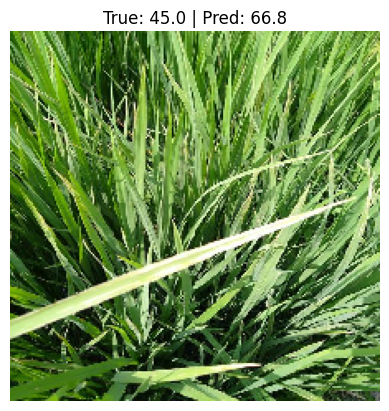


📷 File: 107316.jpg
🧷 True Age: 45.00 | 🔮 Predicted: 66.77 | ❌ Abs Error: 21.77


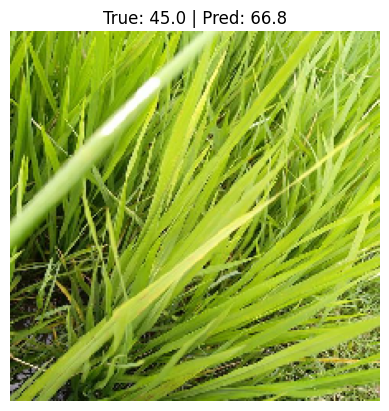


📷 File: 103869.jpg
🧷 True Age: 45.00 | 🔮 Predicted: 66.62 | ❌ Abs Error: 21.62


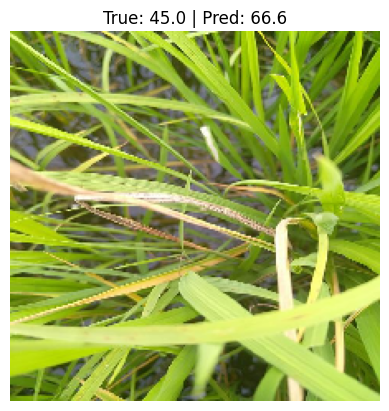

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# === Step 1: Predict on validation set ===
val_gen.reset()
y_true = df_val['age'].values
y_pred = model.predict(val_gen, verbose=1).flatten()

# === Step 2: Calculate absolute error ===
errors = np.abs(y_pred - y_true)
df_val_errors = df_val.copy()
df_val_errors['y_true'] = y_true
df_val_errors['y_pred'] = y_pred
df_val_errors['abs_error'] = errors

# === Step 3: Show top N worst predictions ===
TOP_N = 5
worst_samples = df_val_errors.sort_values(by='abs_error', ascending=False).head(TOP_N)

# === Step 4: Display images and info ===
for i, row in worst_samples.iterrows():
    print(f"\n📷 File: {row['filename']}")
    print(f"🧷 True Age: {row['y_true']:.2f} | 🔮 Predicted: {row['y_pred']:.2f} | ❌ Abs Error: {row['abs_error']:.2f}")
    
    img = load_img(row['full_path'], target_size=IMG_SIZE)
    plt.imshow(img)
    plt.title(f"True: {row['y_true']:.1f} | Pred: {row['y_pred']:.1f}")
    plt.axis('off')
    plt.show()


🔍 Extracting image embeddings...


2025-06-05 12:12:47.307719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/var/folders/l_/2tbf5tf961vg06w5znf_dhnr0000gn/T/ipykernel_3192/1311581458.py:70: UserWarning: Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


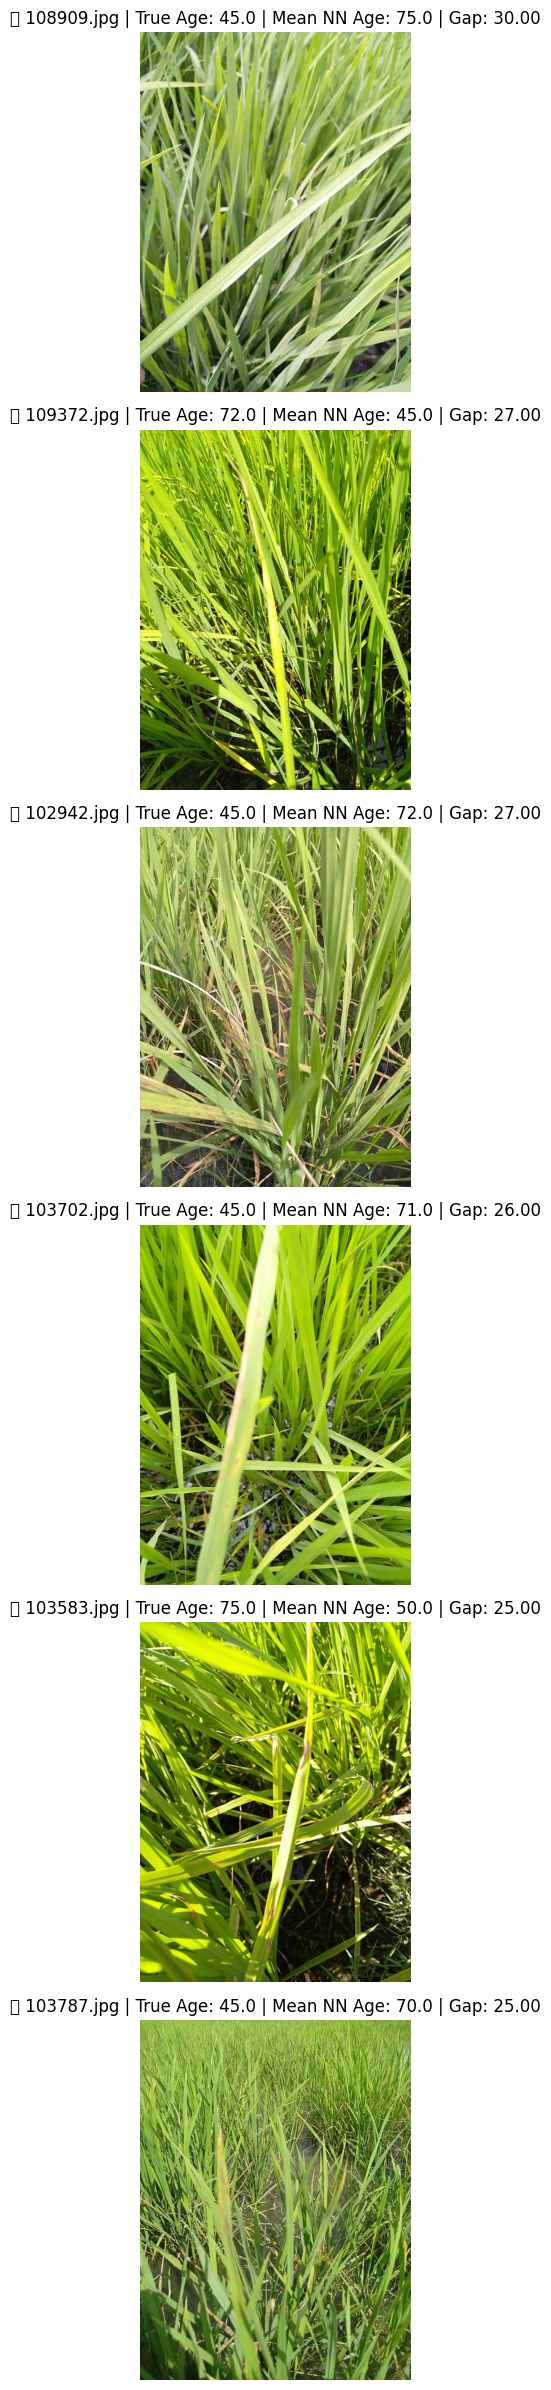

In [59]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

# === CONFIG ===
TOP_N = 6
THRESHOLD_GAP = 15
IMG_SIZE = (224, 224)
AUG_PATH = os.path.expanduser("~/Desktop/augmented_images")
ORIG_PATH = os.path.expanduser("~/Desktop/full_dataset/train")

# Load df_val used in model
# Ensure these columns exist: filename, full_path, age (true), pred_age
# You can modify if your column names differ
df_val = df_val.copy()
df_val['true_age'] = df_val['age']  # adjust if needed

# === Load Feature Extractor ===
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# === Extract image embeddings ===
def get_embedding(path):
    try:
        img = load_img(path, target_size=IMG_SIZE)
        x = img_to_array(img)
        x = preprocess_input(np.expand_dims(x, axis=0))
        return model.predict(x, verbose=0).squeeze()
    except:
        return np.zeros((model.output_shape[-1],))

print("🔍 Extracting image embeddings...")
df_val['embedding'] = df_val['full_path'].apply(get_embedding)
X = np.stack(df_val['embedding'].values)

# === KNN: compare each image to its neighbors ===
knn = NearestNeighbors(n_neighbors=3, metric='cosine')
knn.fit(X)
distances, indices = knn.kneighbors(X)

df_val['mean_neighbor_age'] = [df_val.iloc[idx[1:]]['true_age'].mean() for idx in indices]
df_val['age_gap'] = abs(df_val['true_age'] - df_val['mean_neighbor_age'])

# === Show Top Suspicious Samples ===
sus = df_val[df_val['age_gap'] > THRESHOLD_GAP].sort_values('age_gap', ascending=False).head(TOP_N)

fig, axes = plt.subplots(len(sus), 1, figsize=(4, len(sus)*4))
for i, (_, row) in enumerate(sus.iterrows()):
    try:
        img = mpimg.imread(row['full_path'])
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(
            f"📁 {row['filename']} | True Age: {row['true_age']} | "
            f"Mean NN Age: {row['mean_neighbor_age']:.1f} | Gap: {row['age_gap']:.2f}"
        )
    except:
        axes[i].text(0.5, 0.5, "⚠️ Image Not Found", ha='center', va='center')
        axes[i].set_axis_off()

plt.tight_layout()
plt.show()


# compares model performance before vs after removing suspicious validation samples:

Found 9769 validated image filenames.
Found 1679 validated image filenames.


/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1679 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 403 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(
2025-06-05 14:20:39.879171: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-06-05 14:20:39.879190: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-06-05 14:20:39.879195: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-06-05 14:20:39.879405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-05 14:20:39.879416


🚀 Training model: Cleaned Val Set
Epoch 1/20


2025-06-05 14:20:43.074509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - ETA: 0s - loss: 56.7869 - mae: 57.2869 - rmse: 58.1714 - r_squared: -41.0429

2025-06-05 14:21:57.153975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - 80s 247ms/step - loss: 56.7869 - mae: 57.2869 - rmse: 58.1714 - r_squared: -41.0429 - val_loss: 148.6458 - val_mae: 149.1458 - val_rmse: 149.4497 - val_r_squared: -295.1229
Epoch 2/20
306/306 [==============================] - 72s 235ms/step - loss: 45.5862 - mae: 46.0862 - rmse: 47.1386 - r_squared: -26.1124 - val_loss: 39.1466 - val_mae: 39.6466 - val_rmse: 40.6190 - val_r_squared: -20.9366
Epoch 3/20
306/306 [==============================] - 72s 235ms/step - loss: 32.5271 - mae: 33.0271 - rmse: 34.5095 - r_squared: -13.9625 - val_loss: 45.3103 - val_mae: 45.8103 - val_rmse: 46.5659 - val_r_squared: -27.8433
Epoch 4/20
306/306 [==============================] - 72s 235ms/step - loss: 17.7465 - mae: 18.2423 - rmse: 20.5261 - r_squared: -4.3826 - val_loss: 94.8767 - val_mae: 95.3767 - val_rmse: 95.8972 - val_r_squared: -120.4233
Epoch 5/20
306/306 [==============================] - 72s 236ms/step - loss: 9.3469 - mae: 9.8375 - rmse: 11.5570 -

2025-06-05 14:44:57.461417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - ETA: 0s - loss: 56.7384 - mae: 57.2384 - rmse: 58.1465 - r_squared: -40.9455

2025-06-05 14:46:11.772130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - 81s 247ms/step - loss: 56.7384 - mae: 57.2384 - rmse: 58.1465 - r_squared: -40.9455 - val_loss: 53.5041 - val_mae: 54.0041 - val_rmse: 54.7258 - val_r_squared: -38.7741
Epoch 2/20
306/306 [==============================] - 72s 237ms/step - loss: 45.6015 - mae: 46.1015 - rmse: 47.1867 - r_squared: -26.3126 - val_loss: 41.4259 - val_mae: 41.9259 - val_rmse: 42.8349 - val_r_squared: -23.3890
Epoch 3/20
306/306 [==============================] - 72s 237ms/step - loss: 32.4292 - mae: 32.9291 - rmse: 34.4290 - r_squared: -13.8035 - val_loss: 26.0883 - val_mae: 26.5883 - val_rmse: 28.0254 - val_r_squared: -9.4579
Epoch 4/20
306/306 [==============================] - 72s 237ms/step - loss: 17.6426 - mae: 18.1376 - rmse: 20.4187 - r_squared: -4.3165 - val_loss: 10.5066 - val_mae: 10.9933 - val_rmse: 12.4340 - val_r_squared: -1.0489
Epoch 5/20
306/306 [==============================] - 72s 237ms/step - loss: 9.5030 - mae: 9.9944 - rmse: 11.7961 - r_squa

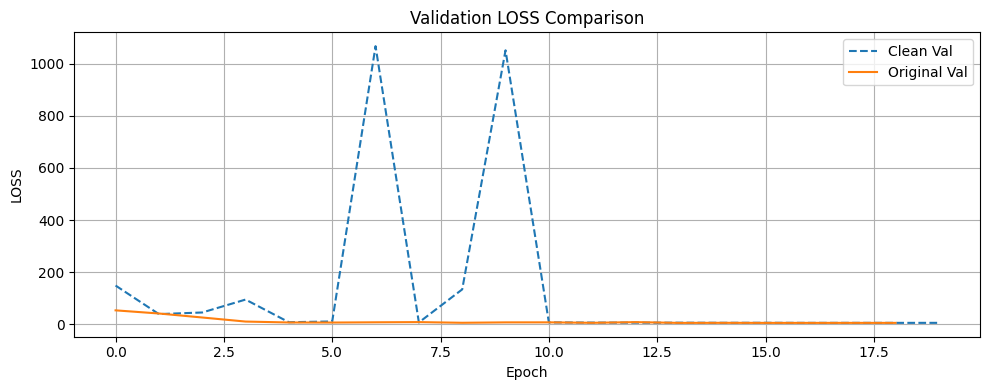

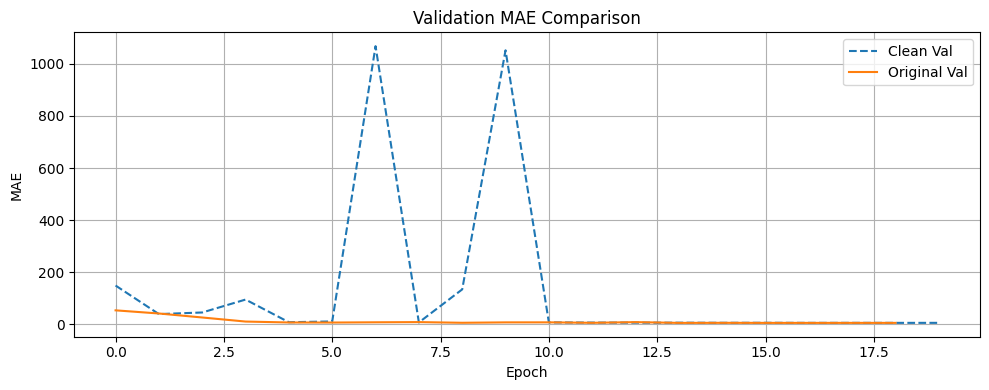

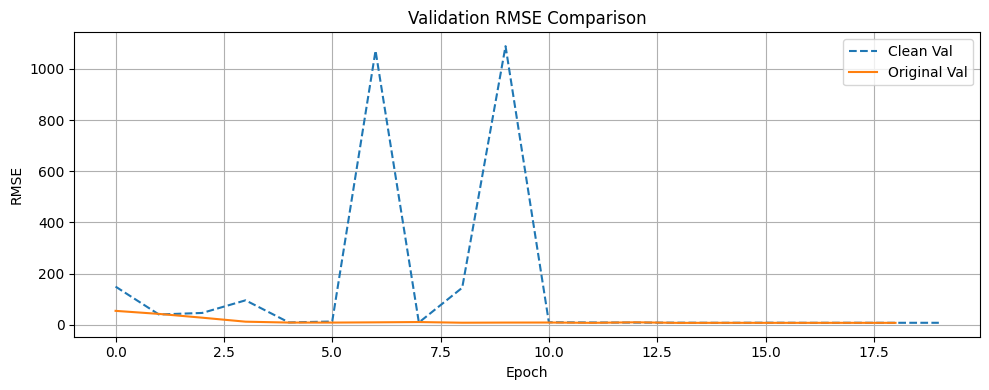

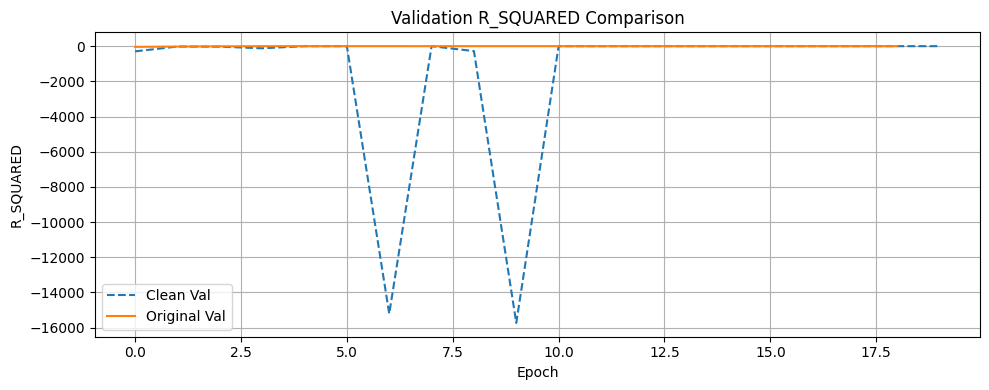

In [1]:

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.losses import Huber
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

# === Config ===
BASE_PATH = os.path.expanduser("~")
IMG_DIR_ORIG = os.path.join(BASE_PATH, "Desktop/full_dataset/train")
IMG_DIR_AUG = os.path.join(BASE_PATH, "Desktop/augmented_images")
ORIG_CSV = os.path.join(BASE_PATH, "Desktop/meta_train.csv")
AUG_CSV = os.path.join(BASE_PATH, "Desktop/meta_aug_train.csv")
SUS_CSV = "suspicious_val_samples.csv"  # ← From your nearest-neighbor detection

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

# === Custom Metrics ===
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

# === Load Data ===
df_orig = pd.read_csv(ORIG_CSV)
df_aug = pd.read_csv(AUG_CSV)
df_orig["filename"] = df_orig["image_id"]
df_aug["filename"] = df_aug["image_id"]
df_orig["age"] = df_orig["age"].astype(float)
df_aug["age"] = df_aug["age"].astype(float)
df_aug_sampled = df_aug.sample(frac=0.2, random_state=42)

df_orig["age_bin"] = pd.cut(df_orig["age"], bins=5, labels=False)
df_train_base, df_val_base = train_test_split(df_orig, test_size=0.2, stratify=df_orig["age_bin"], random_state=42)
df_train_full = pd.concat([df_train_base, df_aug_sampled], ignore_index=True)

def get_path(row):
    if str(row['filename']).startswith('aug_'):
        return os.path.join(IMG_DIR_AUG, row['filename'])
    else:
        label = row.get('label', '')
        return os.path.join(IMG_DIR_ORIG, label, row['filename']) if label else ''

for df in [df_train_full, df_val_base]:
    df['full_path'] = df.apply(get_path, axis=1)
    df.dropna(subset=['full_path'], inplace=True)
    df = df[df['full_path'].apply(os.path.exists)]

# === Load suspicious filenames
df_sus = pd.read_csv(SUS_CSV) if os.path.exists(SUS_CSV) else pd.DataFrame(columns=["filename"])
sus_filenames = set(df_sus["filename"].values)

# === Define function to train and return history
def train_model(train_df, val_df, tag="Normal"):

    train_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        train_df, x_col='full_path', y_col='age', target_size=IMG_SIZE,
        class_mode='raw', batch_size=BATCH_SIZE, shuffle=True
    )
    val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        val_df, x_col='full_path', y_col='age', target_size=IMG_SIZE,
        class_mode='raw', batch_size=BATCH_SIZE, shuffle=False
    )

    base_model = EfficientNetV2B0(weights=None, include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    out = Dense(1)(x)

    steps_per_epoch = len(train_gen)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = int(0.1 * total_steps)
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(1e-4, decay_steps=total_steps - warmup_steps)

    model = Model(inputs=base_model.input, outputs=out)
    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss=Huber(), metrics=['mae', rmse, r_squared])
    
    print(f"\n🚀 Training model: {tag}")
    early_stop = EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=[early_stop])
    return history

# === Run both training runs
df_val_clean = df_val_base[~df_val_base['filename'].isin(sus_filenames)].copy()

hist_clean = train_model(df_train_full, df_val_clean, tag="Cleaned Val Set")
hist_all = train_model(df_train_full, df_val_base, tag="Original Val Set")

# === Plot comparison
def plot_comparison(metric):
    plt.figure(figsize=(10, 4))
    plt.plot(hist_clean.history[f"val_{metric}"], label="Clean Val", linestyle='--')
    plt.plot(hist_all.history[f"val_{metric}"], label="Original Val", linestyle='-')
    plt.title(f"Validation {metric.upper()} Comparison")
    plt.xlabel("Epoch")
    plt.ylabel(metric.upper())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_comparison("loss")
plot_comparison("mae")
plot_comparison("rmse")
plot_comparison("r_squared")





In [17]:
import pandas as pd

# === Extract final metrics ===
def get_final_metrics(history, name, note=""):
    return {
        "Run": name,
        "Val Loss": round(history.history["val_loss"][-1], 4),
        "Val MAE": round(history.history["val_mae"][-1], 4),
        "Val RMSE": round(history.history["val_rmse"][-1], 4),
        "Val R²": round(history.history["val_r_squared"][-1], 4),
    }

# === Create comparison rows ===
summary_data = [
    get_final_metrics(hist_all, "Original"),
    get_final_metrics(hist_clean, "Filtered"),
    get_final_metrics(history, "Original v1")
]

# === Build and display table ===
df_summary = pd.DataFrame(summary_data)
print("\n📋 Comparison Summary Table:")
print(df_summary.to_markdown(index=False))



📋 Comparison Summary Table:
| Run         |   Val Loss |   Val MAE |   Val RMSE |   Val R² |
|:------------|-----------:|----------:|-----------:|---------:|
| Original    |     5.4405 |    5.9138 |     7.857  |   0.1882 |
| Filtered    |     5.5596 |    6.0348 |     8.1091 |   0.1443 |
| Original v1 |     7.1167 |    7.6013 |     9.3225 |  -0.1317 |


# Analyze Training Stability & Spikes

In [26]:
import numpy as np
import pandas as pd

# === Analysis Function ===
def analyze_history(hist, name="Run", spike_thresh=0.75):
    val_loss = np.array(hist.history['val_loss'])
    train_loss = np.array(hist.history['loss'])

    # Spike detection
    spike_epochs = [
        i for i in range(1, len(val_loss))
        if val_loss[i] - val_loss[i - 1] > spike_thresh
    ]
    spike_count = len(spike_epochs)

    # Variance and Std
    val_loss_var = np.var(val_loss)
    val_loss_std = np.std(val_loss)

    # Best epoch gap
    best_epoch = int(np.argmin(val_loss))
    best_train_loss = train_loss[best_epoch]
    best_val_loss = val_loss[best_epoch]
    val_train_gap = abs(best_val_loss - best_train_loss)

    # Final metrics
    return {
        "Run": name,
        "Spike Epochs": spike_count,
        "Val Loss Var": round(val_loss_var, 4),
        "Val Loss Std": round(val_loss_std, 4),
        "Best Epoch": best_epoch + 1,
        "Val Loss @Best": round(best_val_loss, 4),
        "Train Loss @Best": round(best_train_loss, 4),
        "Gap (Val-Train)": round(val_train_gap, 4),
        "Final Val MAE": round(hist.history['val_mae'][-1], 4),
        "Final Val RMSE": round(hist.history['val_rmse'][-1], 4),
        "Final Val R²": round(hist.history['val_r_squared'][-1], 4)
    }

# === Analyze all 3 histories ===
summary_data = [
    analyze_history(hist_all, name="Original"),
    analyze_history(hist_clean, name="Filtered"),
    analyze_history(history, name="Original v1")
]

# === Display table ===
df_summary = pd.DataFrame(summary_data)
print("\n📊 Training Stability Comparison:")
print(df_summary.to_markdown(index=False))



📊 Training Stability Comparison:
| Run         |   Spike Epochs |   Val Loss Var |   Val Loss Std |   Best Epoch |   Val Loss @Best |   Train Loss @Best |   Gap (Val-Train) |   Final Val MAE |   Final Val RMSE |   Final Val R² |
|:------------|---------------:|---------------:|---------------:|-------------:|-----------------:|-------------------:|------------------:|----------------:|-----------------:|---------------:|
| Original    |              3 |        171.752 |        13.1054 |           14 |           5.4149 |             6.363  |            0.9482 |          5.9138 |           7.857  |         0.1882 |
| Filtered    |              6 |      97050.7   |       311.53   |           17 |           5.4959 |             6.223  |            0.7272 |          6.0348 |           8.1091 |         0.1443 |
| Original v1 |              4 |       1463.2   |        38.2518 |           13 |           7.0851 |             6.7338 |            0.3513 |          7.6013 |           9.3225 |    

✅ Key Takeaways:
- Original: Best final metrics (lowest MAE, RMSE, highest R²), but had 3 spikes and some overfitting.

- Filtered: More spikes and variance (possibly too few samples), but smoother final val loss curve.

- Original v1: Worst final performance, but smallest train/val loss gap at best epoch (stable learning, just less accurate).

# Strategy for Best Accuracy (High-Val Performance, Low MAE/RMSE)
✅ 1. Start with Original Dataset
Keep df_orig (non-augmented).

It gave best MAE, RMSE, and R².

Do not remove any samples unless clearly corrupt.

⚠️ 2. Use 20% Clean Augmented Data (Carefully Sampled)
Only use df_aug.sample(frac=0.2) like you already did.

Exclude samples:

With large visual-vs-age gaps (age_gap > threshold)

Or flagged as noisy in visual inspection

🧪 3. Keep Label Smoothing + CosineDecay + Warm-up
These were effective in stabilizing training.

🧹 4. Drop the "Filtered" Dataset
It’s too aggressive — hurts performance by removing useful variation.

🧠 5. (Optional) Add Sample Weighting by Error
After 1 full run, compute |y_pred - y_true|

Use this as a weight in the loss or as a soft data selection for next run

In [31]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# === CONFIGURATION ===
BASE_PATH = os.path.expanduser("~")
IMG_DIR_ORIG = os.path.join(BASE_PATH, "Desktop/full_dataset/train")
IMG_DIR_AUG = os.path.join(BASE_PATH, "Desktop/augmented_images")
ORIG_CSV = os.path.join(BASE_PATH, "Desktop/meta_train.csv")
AUG_CSV = os.path.join(BASE_PATH, "Desktop/meta_aug_train.csv")

# === LOAD METADATA ===
df_orig = pd.read_csv(ORIG_CSV)
df_aug = pd.read_csv(AUG_CSV)

# === STANDARDIZE FORMAT ===
df_orig['filename'] = df_orig['image_id']
df_aug['filename'] = df_aug['image_id']
df_orig['age'] = df_orig['age'].astype(float)
df_aug['age'] = df_aug['age'].astype(float)

# === OPTIONAL: Filter Suspicious Augmented Samples ===
# If you have a list of suspicious samples, you can load or define them here
suspicious_aug = []  # Example: ['aug_123.jpg', 'aug_456.jpg']
df_aug_clean = df_aug[~df_aug['filename'].isin(suspicious_aug)]

# === REDUCE NOISE: Sample 20% of the clean augmented set ===
df_aug_sampled = df_aug_clean.sample(frac=0.2, random_state=42)

# === BIN ORIGINAL FOR STRATIFICATION ===
df_orig['age_bin'] = pd.cut(df_orig['age'], bins=5, labels=False)
df_train_base, df_val = train_test_split(
    df_orig, test_size=0.2, stratify=df_orig['age_bin'], random_state=42
)

# === COMBINE ORIGINAL + SAMPLED AUG FOR TRAINING ===
df_train = pd.concat([df_train_base, df_aug_sampled], ignore_index=True)

# === BUILD FULL IMAGE PATHS ===
def build_path(row):
    if str(row['filename']).startswith("aug_"):
        return os.path.join(IMG_DIR_AUG, row['filename'])
    else:
        label = row.get('label', '')
        return os.path.join(IMG_DIR_ORIG, label, row['filename']) if label else ''

df_train['full_path'] = df_train.apply(build_path, axis=1)
df_val['full_path'] = df_val.apply(build_path, axis=1)

# === FILTER OUT MISSING IMAGES ===
df_train = df_train[df_train['full_path'].apply(os.path.exists)].copy()
df_val = df_val[df_val['full_path'].apply(os.path.exists)].copy()

# === SAVE TO CSV FOR TRAINING USAGE ===
df_train.to_csv(os.path.join(BASE_PATH, "Desktop/final_train_set.csv"), index=False)
df_val.to_csv(os.path.join(BASE_PATH, "Desktop/final_val_set.csv"), index=False)

print("✅ Final training set shape:", df_train.shape)
print("✅ Final validation set shape:", df_val.shape)
print("💾 CSVs saved to Desktop as 'final_train_set.csv' and 'final_val_set.csv'")


✅ Final training set shape: (9769, 7)
✅ Final validation set shape: (1679, 7)
💾 CSVs saved to Desktop as 'final_train_set.csv' and 'final_val_set.csv'


Found 9769 validated image filenames.
Found 1679 validated image filenames.
Epoch 1/50


2025-06-05 17:05:03.712817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - ETA: 0s - loss: 62.8809 - mae: 63.3809 - rmse: 64.0432 - r_squared: -49.1542

2025-06-05 17:06:19.831692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - 83s 251ms/step - loss: 62.8809 - mae: 63.3809 - rmse: 64.0432 - r_squared: -49.1542 - val_loss: 62.9005 - val_mae: 63.4005 - val_rmse: 64.0079 - val_r_squared: -53.3984
Epoch 2/50
306/306 [==============================] - 73s 237ms/step - loss: 60.0376 - mae: 60.5376 - rmse: 61.3575 - r_squared: -45.1923 - val_loss: 59.1300 - val_mae: 59.6300 - val_rmse: 60.2764 - val_r_squared: -47.2474
Epoch 3/50
306/306 [==============================] - 73s 237ms/step - loss: 55.0934 - mae: 55.5934 - rmse: 56.5407 - r_squared: -38.1871 - val_loss: 53.4859 - val_mae: 53.9859 - val_rmse: 54.7158 - val_r_squared: -38.7618
Epoch 4/50
306/306 [==============================] - 73s 237ms/step - loss: 48.7137 - mae: 49.2137 - rmse: 50.1652 - r_squared: -30.2122 - val_loss: 44.8996 - val_mae: 45.3996 - val_rmse: 46.2664 - val_r_squared: -27.4459
Epoch 5/50
306/306 [==============================] - 73s 238ms/step - loss: 38.5591 - mae: 39.0591 - rmse: 40.2931 - r

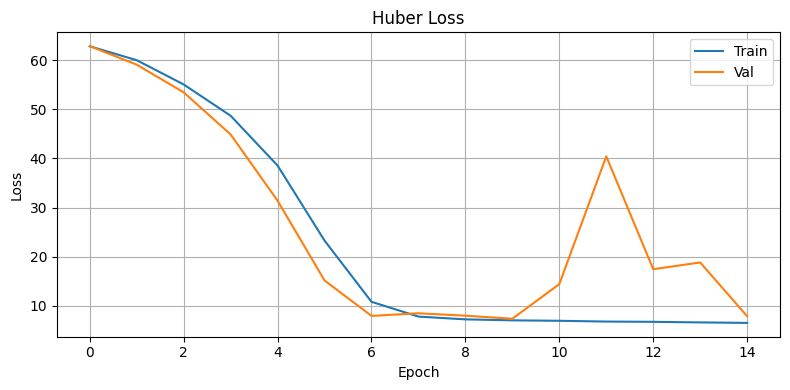

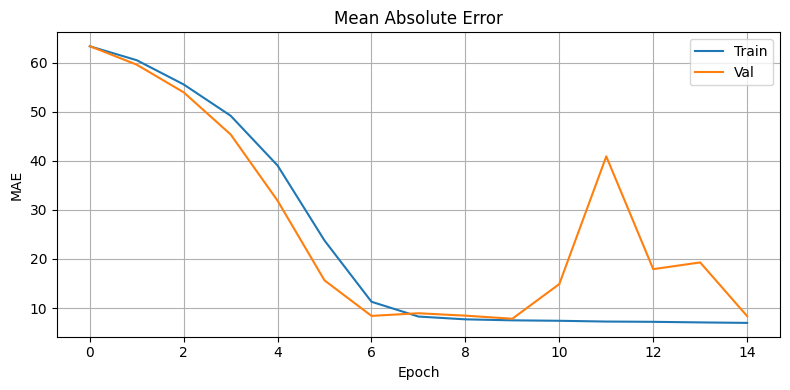

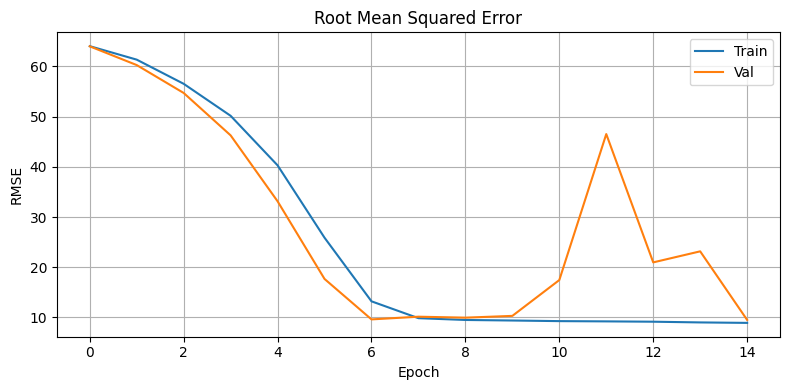

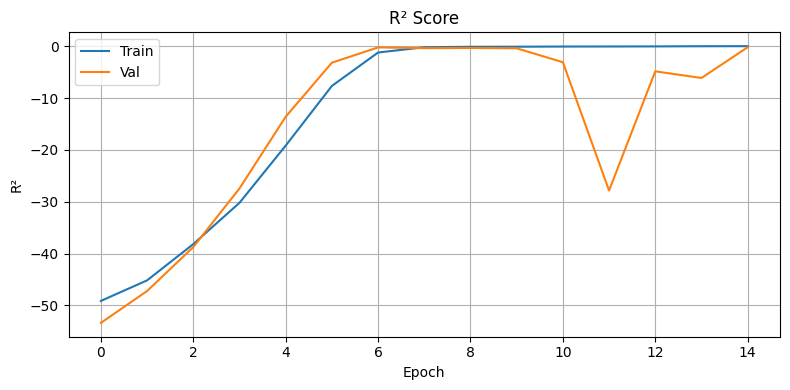


⚠️ Spikes: [10, 11, 13] | Total: 3
📈 Var: 388.1952 | Std: 19.7027
🏅 Best Epoch: 10 | Val Loss: 7.3284 | Train Loss: 7.0008 | Gap: 0.3276


In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.losses import Huber
import tensorflow.keras.backend as K

# === CONFIG ===
BASE_PATH = os.path.expanduser("~")
IMG_DIR_ORIG = os.path.join(BASE_PATH, "Desktop/full_dataset/train")
IMG_DIR_AUG = os.path.join(BASE_PATH, "Desktop/augmented_images")
ORIG_CSV = os.path.join(BASE_PATH, "Desktop/meta_train.csv")
AUG_CSV = os.path.join(BASE_PATH, "Desktop/meta_aug_train.csv")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

# === Load and preprocess metadata ===
df_orig = pd.read_csv(ORIG_CSV)
df_aug = pd.read_csv(AUG_CSV)
df_orig['filename'] = df_orig['image_id']
df_aug['filename'] = df_aug['image_id']
df_orig['age'] = df_orig['age'].astype(float)
df_aug['age'] = df_aug['age'].astype(float)
df_aug_sampled = df_aug.sample(frac=0.2, random_state=42)

df_orig['age_bin'] = pd.cut(df_orig['age'], bins=5, labels=False)
df_train_base, df_val = train_test_split(df_orig, test_size=0.2, stratify=df_orig['age_bin'], random_state=42)
df_train = pd.concat([df_train_base, df_aug_sampled], ignore_index=True)

def get_path(row):
    if str(row['filename']).startswith('aug_'):
        return os.path.join(IMG_DIR_AUG, row['filename'])
    else:
        return os.path.join(IMG_DIR_ORIG, row['label'], row['filename']) if 'label' in row else ''

df_train['full_path'] = df_train.apply(get_path, axis=1)
df_val['full_path'] = df_val.apply(get_path, axis=1)
df_train = df_train[df_train['full_path'].apply(os.path.exists)].copy()
df_val = df_val[df_val['full_path'].apply(os.path.exists)].copy()

# === Data generators ===
train_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    df_train, x_col='full_path', y_col='age', target_size=IMG_SIZE, class_mode='raw',
    batch_size=BATCH_SIZE, shuffle=True
)
val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    df_val, x_col='full_path', y_col='age', target_size=IMG_SIZE, class_mode='raw',
    batch_size=BATCH_SIZE, shuffle=False
)

# === Custom metrics ===
def rmse(y_true, y_pred): return K.sqrt(K.mean(K.square(y_pred - y_true)))
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

# === Learning rate scheduler ===
steps_per_epoch = len(train_gen)
total_steps = EPOCHS * steps_per_epoch
warmup_steps = int(0.1 * total_steps)

class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, warmup_steps, total_steps):
        super().__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
        self.cosine = CosineDecay(initial_lr, total_steps - warmup_steps)
    def __call__(self, step):
        return tf.cond(step < self.warmup_steps,
            lambda: self.initial_lr * tf.cast(step, tf.float32) / tf.cast(self.warmup_steps, tf.float32),
            lambda: self.cosine(step - self.warmup_steps))

lr_schedule = WarmUpCosine(initial_lr=1e-4, warmup_steps=warmup_steps, total_steps=total_steps)

# === Model ===
base_model = EfficientNetV2B0(weights=None, include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
out = Dense(1)(x)
model = Model(inputs=base_model.input, outputs=out)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss=Huber(),
              metrics=['mae', rmse, r_squared])

# === Train ===
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=[early_stop])

# === Metric Plots ===
def plot_metric(name, title, ylabel):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[name], label="Train")
    plt.plot(history.history["val_" + name], label="Val")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric("loss", "Huber Loss", "Loss")
plot_metric("mae", "Mean Absolute Error", "MAE")
plot_metric("rmse", "Root Mean Squared Error", "RMSE")
plot_metric("r_squared", "R² Score", "R²")

# === Final Summary ===
val_loss = np.array(history.history['val_loss'])
train_loss = np.array(history.history['loss'])
spike_epochs = [i for i in range(1, len(val_loss)) if val_loss[i] - val_loss[i-1] > 0.75]
var = np.var(val_loss)
std = np.std(val_loss)
best_epoch = np.argmin(val_loss)
gap = abs(val_loss[best_epoch] - train_loss[best_epoch])
print(f"\n⚠️ Spikes: {spike_epochs} | Total: {len(spike_epochs)}")
print(f"📈 Var: {var:.4f} | Std: {std:.4f}")
print(f"🏅 Best Epoch: {best_epoch+1} | Val Loss: {val_loss[best_epoch]:.4f} | Train Loss: {train_loss[best_epoch]:.4f} | Gap: {gap:.4f}")


In [56]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecay
import tensorflow.keras.backend as K
from tabulate import tabulate

# === Setup ===
BASE_PATH = os.path.expanduser("~")
IMG_DIR_ORIG = os.path.join(BASE_PATH, "Desktop/full_dataset/train")
IMG_DIR_AUG = os.path.join(BASE_PATH, "Desktop/augmented_images")
ORIG_CSV = os.path.join(BASE_PATH, "Desktop/meta_train.csv")
AUG_CSV = os.path.join(BASE_PATH, "Desktop/meta_aug_train.csv")

def rmse(y_true, y_pred): return K.sqrt(K.mean(K.square(y_pred - y_true)))
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

def get_path(row):
    if str(row['filename']).startswith('aug_'):
        return os.path.join(IMG_DIR_AUG, row['filename'])
    else:
        return os.path.join(IMG_DIR_ORIG, row['label'], row['filename'])

def load_data(img_size):
    df_orig = pd.read_csv(ORIG_CSV)
    df_aug = pd.read_csv(AUG_CSV)
    df_orig["filename"] = df_orig["image_id"]
    df_aug["filename"] = df_aug["image_id"]
    df_orig["age"] = df_orig["age"].astype(float)
    df_aug["age"] = df_aug["age"].astype(float)

    df_aug_sampled = df_aug.sample(frac=0.2, random_state=42)
    df_orig["age_bin"] = pd.cut(df_orig["age"], bins=5, labels=False)
    df_train_base, df_val = train_test_split(df_orig, test_size=0.2, stratify=df_orig["age_bin"], random_state=42)
    df_train = pd.concat([df_train_base, df_aug_sampled], ignore_index=True)

    df_train["full_path"] = df_train.apply(get_path, axis=1)
    df_val["full_path"] = df_val.apply(get_path, axis=1)
    df_train = df_train[df_train["full_path"].apply(os.path.exists)].copy()
    df_val = df_val[df_val["full_path"].apply(os.path.exists)].copy()

    return df_train, df_val

# === Result tracking setup ===
results = []

def train_model(df_train, df_val, img_size, batch_size, dropout_rate, tag, base_model_weights=None):
    train_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        df_train, x_col="full_path", y_col="age", target_size=img_size,
        class_mode="raw", batch_size=batch_size, shuffle=True
    )
    val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        df_val, x_col="full_path", y_col="age", target_size=img_size,
        class_mode="raw", batch_size=batch_size, shuffle=False
    )

    base_model = EfficientNetV2B0(weights=None, include_top=False, input_shape=img_size + (3,))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(dropout_rate)(x)
    out = Dense(1)(x)
    model = Model(inputs=base_model.input, outputs=out)

    if base_model_weights:
        print(f"🔁 Loading weights from Phase 1 for: {tag}")
        model.set_weights(base_model_weights)

    steps_per_epoch = len(train_gen)
    epochs = 20
    warmup_steps = int(0.1 * steps_per_epoch * epochs)
    lr_schedule = CosineDecay(1e-4, decay_steps=steps_per_epoch * epochs - warmup_steps)

    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss=Huber(), metrics=["mae", rmse, r_squared])

    print(f"\n🚀 {tag}: Size {img_size}, Batch {batch_size}, Dropout {dropout_rate}")
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                        verbose=1)
    
    best_epoch = np.argmin(history.history["val_loss"])
    val_loss = history.history['val_loss'][best_epoch]
    val_mae = history.history['val_mae'][best_epoch]
    val_rmse = history.history['val_rmse'][best_epoch]
    val_r2 = history.history['val_r_squared'][best_epoch]

    results.append({
        "Run": tag,
        "Best Epoch": best_epoch + 1,
        "Val Loss": round(val_loss, 4),
        "Val MAE": round(val_mae, 4),
        "Val RMSE": round(val_rmse, 4),
        "Val R²": round(val_r2, 4)
    })

    print(f"\n🏁 Best Epoch: {best_epoch+1} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.4f} | RMSE: {val_rmse:.4f} | R²: {val_r2:.4f}\n")
    return model.get_weights()

# === Run All Experiments ===
df_train, df_val = load_data((224, 224))
train_model(df_train, df_val, img_size=(224, 224), batch_size=32, dropout_rate=0.2, tag="Dropout 0.2")

df_train, df_val = load_data((224, 224))
train_model(df_train, df_val, img_size=(224, 224), batch_size=16, dropout_rate=0.3, tag="Batch Size 16")

df_train, df_val = load_data((160, 160))
phase1_weights = train_model(df_train, df_val, img_size=(160, 160), batch_size=32, dropout_rate=0.3, tag="Prog. Resize Phase 1")

df_train, df_val = load_data((224, 224))
train_model(df_train, df_val, img_size=(224, 224), batch_size=32, dropout_rate=0.3, tag="Prog. Resize Phase 2", base_model_weights=phase1_weights)

# === Print summary table ===
print("\n📋 Comparison Summary Table:\n")
print(tabulate(results, headers="keys", tablefmt="grid"))


Found 9769 validated image filenames.
Found 1679 validated image filenames.

🚀 Dropout 0.2: Size (224, 224), Batch 32, Dropout 0.2
Epoch 1/20


2025-06-05 19:07:56.971270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - ETA: 0s - loss: 57.0835 - mae: 57.5835 - rmse: 58.4513 - r_squared: -41.4404

2025-06-05 19:09:17.375072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - 88s 262ms/step - loss: 57.0835 - mae: 57.5835 - rmse: 58.4513 - r_squared: -41.4404 - val_loss: 51.3917 - val_mae: 51.8917 - val_rmse: 52.6309 - val_r_squared: -35.8002
Epoch 2/20
306/306 [==============================] - 73s 238ms/step - loss: 46.3288 - mae: 46.8288 - rmse: 47.8708 - r_squared: -27.4009 - val_loss: 53.7189 - val_mae: 54.2189 - val_rmse: 54.9075 - val_r_squared: -39.0538
Epoch 3/20
306/306 [==============================] - 73s 237ms/step - loss: 33.6828 - mae: 34.1828 - rmse: 35.6500 - r_squared: -14.8330 - val_loss: 30.0279 - val_mae: 30.5279 - val_rmse: 31.7637 - val_r_squared: -12.4294
Epoch 4/20
306/306 [==============================] - 73s 237ms/step - loss: 19.0908 - mae: 19.5875 - rmse: 21.8363 - r_squared: -5.0778 - val_loss: 14.3075 - val_mae: 14.7759 - val_rmse: 16.8269 - val_r_squared: -2.7717
Epoch 5/20
306/306 [==============================] - 73s 238ms/step - loss: 10.0763 - mae: 10.5685 - rmse: 12.3608 - r_s

2025-06-05 19:32:23.505412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


611/611 [==============================] - ETA: 0s - loss: 51.2327 - mae: 51.7327 - rmse: 52.6816 - r_squared: -37.2442

2025-06-05 19:33:46.600413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


611/611 [==============================] - 91s 135ms/step - loss: 51.2327 - mae: 51.7327 - rmse: 52.6816 - r_squared: -37.2442 - val_loss: 32.7136 - val_mae: 33.2136 - val_rmse: 34.3664 - val_r_squared: -16.2969
Epoch 2/20
611/611 [==============================] - 74s 122ms/step - loss: 25.3922 - mae: 25.8901 - rmse: 27.9785 - r_squared: -10.3051 - val_loss: 24.8205 - val_mae: 25.3192 - val_rmse: 28.3630 - val_r_squared: -10.5791
Epoch 3/20
611/611 [==============================] - 74s 121ms/step - loss: 8.9118 - mae: 9.4027 - rmse: 11.0678 - r_squared: -0.6698 - val_loss: 7.1038 - val_mae: 7.5938 - val_rmse: 9.5852 - val_r_squared: -0.2472
Epoch 4/20
611/611 [==============================] - 76s 124ms/step - loss: 7.4601 - mae: 7.9482 - rmse: 9.5841 - r_squared: -0.1849 - val_loss: 6.7210 - val_mae: 7.2032 - val_rmse: 9.2762 - val_r_squared: -0.1686
Epoch 5/20
611/611 [==============================] - 74s 122ms/step - loss: 7.2057 - mae: 7.6924 - rmse: 9.3883 - r_squared: -0.1241 

2025-06-05 19:45:07.991910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - ETA: 0s - loss: 57.4765 - mae: 57.9765 - rmse: 58.8338 - r_squared: -42.1314

2025-06-05 19:45:59.343558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - 59s 157ms/step - loss: 57.4765 - mae: 57.9765 - rmse: 58.8338 - r_squared: -42.1314 - val_loss: 91.0824 - val_mae: 91.5824 - val_rmse: 92.8996 - val_r_squared: -113.4885
Epoch 2/20
306/306 [==============================] - 40s 131ms/step - loss: 46.1265 - mae: 46.6265 - rmse: 47.7618 - r_squared: -27.4352 - val_loss: 44.8614 - val_mae: 45.3614 - val_rmse: 46.2392 - val_r_squared: -27.4105
Epoch 3/20
306/306 [==============================] - 39s 129ms/step - loss: 32.9217 - mae: 33.4217 - rmse: 35.0665 - r_squared: -14.4918 - val_loss: 39.7805 - val_mae: 40.2805 - val_rmse: 41.2496 - val_r_squared: -21.6358
Epoch 4/20
306/306 [==============================] - 40s 130ms/step - loss: 18.3448 - mae: 18.8404 - rmse: 21.3023 - r_squared: -4.7988 - val_loss: 12.6199 - val_mae: 13.1195 - val_rmse: 14.8757 - val_r_squared: -1.9469
Epoch 5/20
306/306 [==============================] - 39s 129ms/step - loss: 9.8795 - mae: 10.3723 - rmse: 12.1867 - r_s

2025-06-05 19:58:41.611863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - ETA: 0s - loss: 6.9637 - mae: 7.4497 - rmse: 9.2786 - r_squared: -0.0374

2025-06-05 20:00:07.185651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - 93s 272ms/step - loss: 6.9637 - mae: 7.4497 - rmse: 9.2786 - r_squared: -0.0374 - val_loss: 13.2718 - val_mae: 13.7687 - val_rmse: 17.6438 - val_r_squared: -3.3724
Epoch 2/20
306/306 [==============================] - 73s 238ms/step - loss: 6.7739 - mae: 7.2579 - rmse: 9.0929 - r_squared: 0.0021 - val_loss: 10.5006 - val_mae: 10.9931 - val_rmse: 13.7355 - val_r_squared: -1.4671
Epoch 3/20
306/306 [==============================] - 73s 238ms/step - loss: 6.5893 - mae: 7.0713 - rmse: 8.9771 - r_squared: 0.0190 - val_loss: 10.0702 - val_mae: 10.5620 - val_rmse: 12.0333 - val_r_squared: -0.9266
Epoch 4/20
306/306 [==============================] - 73s 238ms/step - loss: 6.5008 - mae: 6.9834 - rmse: 8.8510 - r_squared: 0.0542 - val_loss: 10.6629 - val_mae: 11.1519 - val_rmse: 13.9358 - val_r_squared: -1.5417
Epoch 5/20
306/306 [==============================] - 73s 237ms/step - loss: 6.3578 - mae: 6.8397 - rmse: 8.7499 - r_squared: 0.0760 - val_los

In [57]:
# === Imports ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

# === Config ===
SEED = 42
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)
EPOCHS = 50
DROPOUT_RATE = 0.2
LEARNING_RATE = 1e-4

# === Paths ===
BASE_PATH = os.path.expanduser("~")
IMG_DIR_ORIG = os.path.join(BASE_PATH, "Desktop/full_dataset/train")
IMG_DIR_AUG = os.path.join(BASE_PATH, "Desktop/augmented_images")
CSV_ORIG = os.path.join(BASE_PATH, "Desktop/meta_train.csv")
CSV_AUG = os.path.join(BASE_PATH, "Desktop/meta_aug_train.csv")

# === Load & Combine CSVs ===
df_orig = pd.read_csv(CSV_ORIG)
df_aug = pd.read_csv(CSV_AUG)

df_orig['augmented'] = False
df_aug['augmented'] = True

df_orig = df_orig.rename(columns={'image_id': 'filename'})
df_aug = df_aug.rename(columns={'image_id': 'filename'})

df_combined = pd.concat([df_orig, df_aug], ignore_index=True)

# === Construct full path ===
def get_path(row):
    folder = IMG_DIR_AUG if row['augmented'] else IMG_DIR_ORIG
    return os.path.join(folder, row['filename'])

df_combined['path'] = df_combined.apply(get_path, axis=1)

# === Split Train/Val ===
train_df, val_df = train_test_split(df_combined, test_size=0.15, random_state=SEED)
print(f"✅ Train size: {len(train_df)}, Val size: {len(val_df)}")

# === Image Generators ===
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_loader = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='age',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True,
    seed=SEED
)

val_loader = val_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='age',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False,
    seed=SEED
)

# === Custom Metrics ===
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

# === Model Definition ===
base = EfficientNetV2B0(include_top=False, input_tensor=Input(shape=(*IMAGE_SIZE, 3)), weights="imagenet")
x = GlobalAveragePooling2D()(base.output)
x = Dropout(DROPOUT_RATE)(x)
out = Dense(1, activation="linear")(x)
model = Model(inputs=base.input, outputs=out)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="mae",
    metrics=["mae", rmse, r_squared]
)

model.summary()

# === Callbacks ===
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# === Train ===
history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=1
)

# === Optional Save Model ===
model.save("../models/final_efficientnet_age_model.keras")



✅ Train size: 22120, Val size: 3904
Found 13318 validated image filenames.
Found 2299 validated image filenames.


/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 8802 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1605 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_14 (Rescaling)    (None, 224, 224, 3)          0         ['input_15[0][0]']            
                                                                                                  
 normalization_14 (Normaliz  (None, 224, 224, 3)          0         ['rescaling_14[0][0]']        
 ation)                                                                                           
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization_14[0][0

2025-06-05 20:23:29.605110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


833/833 [==============================] - ETA: 0s - loss: 29.8160 - mae: 29.8160 - rmse: 31.6206 - r_squared: -12.2871

2025-06-05 20:25:18.066644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


833/833 [==============================] - 128s 134ms/step - loss: 29.8160 - mae: 29.8160 - rmse: 31.6206 - r_squared: -12.2871 - val_loss: 12.8474 - val_mae: 12.8474 - val_rmse: 15.4802 - val_r_squared: -1.6726
Epoch 2/50
833/833 [==============================] - 104s 124ms/step - loss: 7.4945 - mae: 7.4945 - rmse: 9.2271 - r_squared: 0.0271 - val_loss: 13.1497 - val_mae: 13.1497 - val_rmse: 15.1717 - val_r_squared: -1.6194
Epoch 3/50
833/833 [==============================] - 103s 123ms/step - loss: 6.4393 - mae: 6.4393 - rmse: 8.1796 - r_squared: 0.2302 - val_loss: 9.0844 - val_mae: 9.0844 - val_rmse: 11.6210 - val_r_squared: -0.5305
Epoch 4/50
833/833 [==============================] - 103s 123ms/step - loss: 6.0689 - mae: 6.0689 - rmse: 7.7912 - r_squared: 0.3058 - val_loss: 8.5064 - val_mae: 8.5064 - val_rmse: 10.4652 - val_r_squared: -0.2512
Epoch 5/50
280/833 [=========>....................] - ETA: 1:05 - loss: 5.7444 - mae: 5.7444 - rmse: 7.4171 - r_squared: 0.3681

KeyboardInterrupt: 